[notebooks](https://github.com/apache/spark/blob/master/examples/src/main/python/mllib/linear_regression_with_sgd_example.py)

In [5]:
import os
import pandas as pd

In [6]:
os.chdir('/usr/local/spark')

In [7]:
! ls examples/src/main/python/mllib | head -4

binary_classification_metrics_example.py
bisecting_k_means_example.py
correlations_example.py
correlations.py


In [8]:
! ls ./data/mllib/ | head -4

acme.csv
als
gmm_data.txt
images


In [6]:
#! head ./data/mllib/sample_multiclass_classification_data.txt
#./data/mllib/sample_linear_regression_data.txt

[directory example data](https://vincentarelbundock.github.io/Rdatasets/datasets.html)

```
wget --directory-prefix=/usr/local/spark/data/mllib/ \
          https://vincentarelbundock.github.io/Rdatasets/csv/boot/acme.csv
```

# Config

In [9]:
from pyspark import SparkConf, SparkContext
from pyspark import SQLContext

conf = (SparkConf()
            .setMaster("local[*]")
            .setAppName("My app")
            .set("spark.executor.memory","1g"))

sc = SparkContext(conf = conf)

In [10]:
from pyspark import SQLContext
sqlctx = SQLContext(sc)

In [28]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Common Idioms

### Loading Data

In [ ]:
# read csv: simple
spark.read.csv("some_input_file.csv", header=True, mode="DROPMALFORMED", schema=schema)

In [ ]:
# read csv: complex
(spark.read
    .schema(schema)
    .option("header", "true")
    .option("mode", "DROPMALFORMED")
    .csv("some_input_file.csv"))

### Transform Data

In [ ]:
# mapping
#https://stackoverflow.com/questions/41819294/spark-rdd-mapping-questions
data = [["no1", "1|3|4"], ["no2", "4|5|6"]]
df = sc.parallelize( data ).toDF(["A","B"])
df.withColumn("B", explode(split("B", "\\|"))).show()

In [32]:
# pivot data
rdd = sc.parallelize([('X01',41,'US',3),
                       ('X01',41,'UK',1),
                       ('X01',41,'CA',2),
                       ('X02',72,'US',4),
                       ('X02',72,'UK',6),
                       ('X02',72,'CA',7),
                       ('X02',72,'XX',8)])

# convert to a Spark DataFrame                    
schema = StructType([StructField('ID', StringType(), True),
                     StructField('Age', IntegerType(), True),
                     StructField('Country', StringType(), True),
                     StructField('Score', IntegerType(), True)])

df = sqlctx.createDataFrame(rdd, schema)

pivoted = (df
    .groupBy("ID", "Age")
    .pivot(
        "Country",
        ['US', 'UK', 'CA'])  # Optional list of levels
    .sum("Score"))  # alternatively you can use .agg(expr))
pivoted.show()

+---+---+---+---+---+
| ID|Age| US| UK| CA|
+---+---+---+---+---+
|X02| 72|  4|  6|  7|
|X01| 41|  3|  1|  2|
+---+---+---+---+---+



### Sampling

In [ ]:
# typical sampling
splits = vdf.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# stratified sampling
#https://stackoverflow.com/questions/32238727/stratified-sampling-in-spark?noredirect=1&lq=1

### Example: ridge-data.data

In [8]:
! cat ./data/mllib/ridge-data/lpsa.data | head -3

-0.4307829,-1.63735562648104 -2.00621178480549 -1.86242597251066 -1.02470580167082 -0.522940888712441 -0.863171185425945 -1.04215728919298 -0.864466507337306
-0.1625189,-1.98898046126935 -0.722008756122123 -0.787896192088153 -1.02470580167082 -0.522940888712441 -0.863171185425945 -1.04215728919298 -0.864466507337306
-0.1625189,-1.57881887548545 -2.1887840293994 1.36116336875686 -1.02470580167082 -0.522940888712441 -0.863171185425945 0.342627053981254 -0.155348103855541


In [178]:
from pyspark.mllib.regression import LabeledPoint

# Load and parse the data
def parsePoint(line):
        values = [float(x) for x in line.replace(',', ' ').split(' ')]
        return LabeledPoint(values[0], values[1:])

data = sc.textFile("data/mllib/ridge-data/lpsa.data")
parsedData = data.map(parsePoint)
df = parsedData.toDF()
parsedData.cache()

PythonRDD[415] at RDD at PythonRDD.scala:49

In [179]:
parsedData.take(3)

[LabeledPoint(-0.4307829, [-1.63735562648,-2.00621178481,-1.86242597251,-1.02470580167,-0.522940888712,-0.863171185426,-1.04215728919,-0.864466507337]),
 LabeledPoint(-0.1625189, [-1.98898046127,-0.722008756122,-0.787896192088,-1.02470580167,-0.522940888712,-0.863171185426,-1.04215728919,-0.864466507337]),
 LabeledPoint(-0.1625189, [-1.57881887549,-2.1887840294,1.36116336876,-1.02470580167,-0.522940888712,-0.863171185426,0.342627053981,-0.155348103856])]

In [191]:
sampled_data.loc[0,'_1']

-0.43078290000000002

In [188]:
def parseRow(line):
    row = line.replace(',', ' ').split(' ')
    num_row = [float(x) for x in row]
    return num_row

rowData = data.map(parseRow)  
dfRow = rowData.toDF()
dfRow.count()

67

__Matrix Scatter Plot__

In [190]:
import pandas as pd

#numeric_features = [t[0] for t in dfRow.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = dfRow.sample(False, 0.8).toPandas()

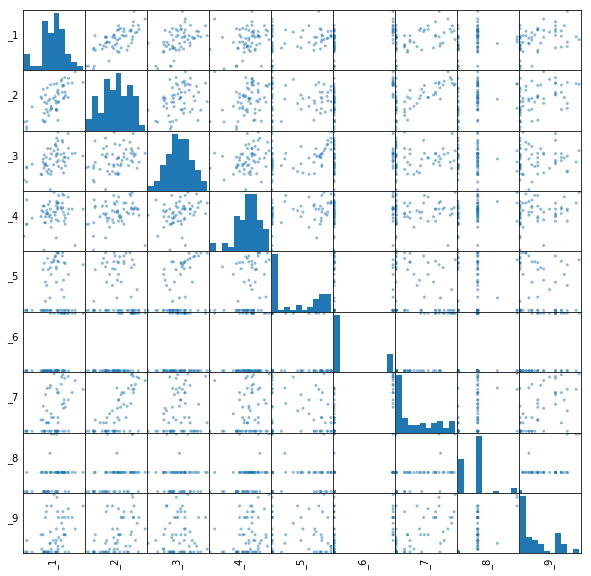

In [197]:
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [203]:
import six
for i in dfRow.columns:
    if not( isinstance(dfRow.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to _1 for ", i, dfRow.stat.corr('_1',i))

Correlation to _1 for  _1 1.0
Correlation to _1 for  _2 0.7331551466472076
Correlation to _1 for  _3 0.4852151924559807
Correlation to _1 for  _4 0.22764238263775488
Correlation to _1 for  _5 0.26293762919961366
Correlation to _1 for  _6 0.5568864323991328
Correlation to _1 for  _7 0.48920320360083785
Correlation to _1 for  _8 0.34242780892704544
Correlation to _1 for  _9 0.44804795486356774


__Principal Component Analysis__

* [paper](https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/)
* [notebook](https://github.com/asdspal/dimRed/blob/master/PCA.ipynb)

* [ref: pca in ml](https://stackoverflow.com/questions/31774311/pca-analysis-in-pyspark)
* [ref: by-hand](https://stackoverflow.com/questions/33428589/pyspark-and-pca-how-can-i-extract-the-eigenvectors-of-this-pca-how-can-i-calcu/33481471#33481471)
* [ref: create scree chart](https://stats.stackexchange.com/questions/12819/how-to-draw-a-scree-plot-in-python)
* [ref: upper-limit to features](https://stackoverflow.com/questions/40262539/pca-in-spark-mllib-and-spark-ml?rq=1)



In [204]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors  

df = sqlctx.createDataFrame([
   (Vectors.dense([1, 2, 0]),),
   (Vectors.dense([2, 0, 1]),),
   (Vectors.dense([0, 1, 0]),)], ("features", ))

pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(df)
transformed = model.transform(df)

In [206]:
transformed.collect()

[Row(features=DenseVector([1.0, 2.0, 0.0]), pca=DenseVector([0.6396, -2.1213])),
 Row(features=DenseVector([2.0, 0.0, 1.0]), pca=DenseVector([-1.7056, -1.4142])),
 Row(features=DenseVector([0.0, 1.0, 0.0]), pca=DenseVector([0.6396, -0.7071]))]

__Modeling: ml__

[ref](https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a)

In [209]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['_2','_3','_4','_4','_5','_6','_7','_8','_9'], outputCol = 'features')
vdf = vectorAssembler.transform(dfRow)
vdf = vdf.select(['features', '_1'])
vdf.show(3)

+--------------------+----------+
|            features|        _1|
+--------------------+----------+
|[-1.6373556264810...|-0.4307829|
|[-1.9889804612693...|-0.1625189|
|[-1.5788188754854...|-0.1625189|
+--------------------+----------+
only showing top 3 rows



In [210]:
splits = vdf.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [211]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='_1', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.382371124447,0.0675261969889,0.0,0.0,0.0,0.0716751493222,0.0,0.0,0.0314257699558]
Intercept: 2.5635112031966694


In [212]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.828866
r2: 0.424081


In [213]:
train_df.describe().show()

+-------+------------------+
|summary|                _1|
+-------+------------------+
|  count|                41|
|   mean|2.5341211756097564|
| stddev|1.1057724875608432|
|    min|        -0.1625189|
|    max|          5.477509|
+-------+------------------+



In [215]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","_1","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="_1",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----------+--------------------+
|        prediction|        _1|            features|
+------------------+----------+--------------------+
|1.6895796103443412|-0.1625189|[-1.9889804612693...|
|1.7373134471173783|-0.4307829|[-1.6373556264810...|
|1.8442819266630117| 1.6956156|[-1.6075825233883...|
|1.7696523928831196|-0.1625189|[-1.5788188754854...|
|1.9417156337334538| 1.4701758|[-1.4979532991854...|
+------------------+----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.501748


In [216]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.945663


In [217]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.48241414246091124, 0.4209399568868573, 0.4154342336458053, 0.40571659623012346, 0.40432628865563364, 0.4043044108997696, 0.4042958020055172, 0.4042885850071366, 0.4042874763919305, 0.4042863803020178]
+--------------------+
|           residuals|
+--------------------+
|-0.35215386982329155|
|  -1.778254434032034|
| -0.8917718619024751|
| -0.2634383777467313|
| 0.05501280125641839|
| -0.3018587885248303|
|  0.1633121405635123|
|  -0.519497001904385|
|0.040141996340826935|
|0.022967832698296498|
| -1.4172507594489656|
| 0.04914907564908688|
|   -0.56025370265697|
| -0.7611023849019907|
| -0.3861748020262632|
| -1.0981619604046287|
|-0.00900113265857172|
|  -1.024445844855215|
| -1.2552706791930306|
| -1.3136386176668977|
+--------------------+
only showing top 20 rows



In [218]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","_1","features").show()

+------------------+----------+--------------------+
|        prediction|        _1|            features|
+------------------+----------+--------------------+
|1.6895796103443412|-0.1625189|[-1.9889804612693...|
|1.7373134471173783|-0.4307829|[-1.6373556264810...|
|1.8442819266630117| 1.6956156|[-1.6075825233883...|
|1.7696523928831196|-0.1625189|[-1.5788188754854...|
|1.9417156337334538| 1.4701758|[-1.4979532991854...|
|2.1510015105257834| 1.5993876|[-0.9907206654908...|
|2.1395924944412394| 1.2669476|[-0.9293604631477...|
|2.2736829587138354| 0.3715636|[-0.5078744753006...|
|2.3813995683048805|  2.008214|[-0.0633337899773...|
| 2.580201243581155| 2.5533438|[0.26634132994993...|
|2.6778123009099795| 1.7137979|[0.36627391851114...|
|  2.80274319148821| 1.8946169|[0.89904311736923...|
|2.2327312990879173| 2.7942279|[-0.7519572860173...|
|2.6352860378133496| 2.9729753|[-0.1324315440812...|
|2.5912696651478213| 2.7180005|[-0.0704736333296...|
|2.6949729896955277|  2.677591|[0.263121415733

__Modeling: mllib__

In [74]:
from pyspark.mllib.regression import LinearRegressionWithSGD, LinearRegressionModel

model = LinearRegressionWithSGD.train(parsedData, iterations=100, step=0.00000001)

In [75]:
valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
MSE = valuesAndPreds \
        .map(lambda vp: (vp[0] - vp[1])**2) \
        .reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 7.4510328101


In [ ]:
# Save and load model
#model.save(sc, "target/tmp/pythonLinearRegressionWithSGDModel")
#sameModel = LinearRegressionModel.load(sc, "target/tmp/pythonLinearRegressionWithSGDModel")

__Example: acme.csv__ 

In [35]:
! head -5 /usr/local/spark/data/mllib/acme.csv

"","month","market","acme"
"1","1/86",-0.061134,0.03016
"2","2/86",0.00822,-0.165457
"3","3/86",-0.007381,0.080137
"4","4/86",-0.067561,-0.109917


[ref: read csv](https://stackoverflow.com/questions/29704333/spark-load-csv-file-as-dataframe)

In [72]:
df = sqlctx.sql("SELECT * FROM csv.`/usr/local/spark/data/mllib/acme.csv`")
df.take(3)

[Row(_c0=None, _c1='month', _c2='market', _c3='acme'),
 Row(_c0='1', _c1='1/86', _c2='-0.061134', _c3='0.03016'),
 Row(_c0='2', _c1='2/86', _c2='0.00822', _c3='-0.165457')]

In [29]:
df = sqlctx.read.format("csv")  \
            .option("header", "true")  \
            .option("mode", "DROPMALFORMED") \
            .load("/usr/local/spark/data/mllib/acme.csv")

In [53]:
from pyspark.sql.functions import dayofmonth, from_unixtime, month, unix_timestamp, year

x = from_unixtime(unix_timestamp(df['month'], "MM/yy"))
df.withColumn("newDt",x).take(3)

In [57]:
df.take(5)

[Row(_c0='1', month='1/86', market='-0.061134', acme='0.03016'),
 Row(_c0='2', month='2/86', market='0.00822', acme='-0.165457'),
 Row(_c0='3', month='3/86', market='-0.007381', acme='0.080137'),
 Row(_c0='4', month='4/86', market='-0.067561', acme='-0.109917'),
 Row(_c0='5', month='5/86', market='-0.006238', acme='-0.114853')]

In [58]:
#FAIL
df.select(to_timestamp(df.month, 'MM/YY').alias('dt')).take(3)

[Row(dt=datetime.datetime(1985, 12, 29, 0, 0)),
 Row(dt=datetime.datetime(1985, 12, 29, 0, 0)),
 Row(dt=datetime.datetime(1985, 12, 29, 0, 0))]

In [59]:
print( df.head() )
print( df.describe() )
print( df.printSchema() )
print( df.count() )

Row(_c0='1', month='1/86', market='-0.061134', acme='0.03016')
DataFrame[summary: string, _c0: string, month: string, market: string, acme: string]
root
 |-- _c0: string (nullable = true)
 |-- month: string (nullable = true)
 |-- market: string (nullable = true)
 |-- acme: string (nullable = true)

None
60


__date-time examples__

[references](https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format)

In [67]:
from pyspark.sql.functions import unix_timestamp

df = sqlctx.createDataFrame([("11/25/1991",), ("11/24/1991",), ("11/30/1991",)], ['date_str'])
df2 = df.select('date_str', from_unixtime(unix_timestamp('date_str', 'MM/dd/yyy')).alias('date'))
df2.take(3)

[Row(date_str='11/25/1991', date='1991-11-25 00:00:00'),
 Row(date_str='11/24/1991', date='1991-11-24 00:00:00'),
 Row(date_str='11/30/1991', date='1991-11-30 00:00:00')]

In [68]:
df = sqlctx.createDataFrame([('1997-02-28 10:30:00',)], ['t'])
df.select(to_timestamp(df.t, 'yyyy-MM-dd HH:mm:ss').alias('dt')).collect()

[Row(dt=datetime.datetime(1997, 2, 28, 10, 30))]

In [6]:
data = range(1,1000)

In [7]:
rdd = sc.parallelize(data)

In [8]:
#rdd.collect()
rdd.take(5)
x = rdd.take(5)

### Create dataframe

[ref](https://stackoverflow.com/questions/39699107/spark-rdd-to-dataframe-python)

__Dynamically create__

In [ ]:
from pyspark.sql.types import Row

#here you are going to create a function
def f(x):
    d = {}
    for i in range(len(x)):
        d[str(i)] = x[i]
    return d

#Now populate that
df = rdd.map(lambda x: Row(**f(x))).toDF()

In [ ]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType

schema = StructType([StructField(str(i), StringType(), True) for i in range(32)])

df = sqlContext.createDataFrame(rdd, schema)

In [15]:
x = rdd.toDF

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
       .builder \
       .appName("Python Spark SQL basic example") \
       .config("spark.some.config.option", "some-value") \
       .getOrCreate()

In [ ]:
from pyspark.sql.types import *

sc = spark.sparkContext
lines = sc.textFile("people.txt")

In [27]:
! ls data

graphx	mllib  streaming  test.csv  train.csv


In [38]:
test = pd.read_csv("./data/test.csv")
train = pd.read_csv("./data/train.csv")

In [50]:
Train = scc.createDataFrame(train)
Test = scc.createDataFrame(test)

In [58]:
Train.count(), Test.count()

(550068, 233599)

In [55]:
Train.printSchema()

root
 |-- User_ID: long (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: long (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: long (nullable = true)
 |-- Product_Category_1: long (nullable = true)
 |-- Product_Category_2: double (nullable = true)
 |-- Product_Category_3: double (nullable = true)
 |-- Purchase: long (nullable = true)



In [57]:
Train.na.drop().count(), Test.na.drop('any').count()

(166821, 71037)

In [59]:
Train = Train.fillna(-1)
Test = Test.fillna(-1)

In [61]:
Train.select('Product_ID').show(5)

+----------+
|Product_ID|
+----------+
| P00069042|
| P00248942|
| P00087842|
| P00085442|
| P00285442|
+----------+
only showing top 5 rows



In [62]:
Train.select('Product_ID').distinct().count(), Test.select('Product_ID').distinct().count()

(3631, 3491)

In [63]:
diff_cat_in_train_test = Test.select('Product_ID').subtract(Train.select('Product_ID'))
diff_cat_in_train_test.distinct().count()# For distict count

46

In [64]:
type(diff_cat_in_train_test)

pyspark.sql.dataframe.DataFrame

In [97]:
from pyspark.ml.feature import StringIndexer

plan_indexer = StringIndexer(inputCol = 'Product_ID', outputCol = 'product-id')
labeller = plan_indexer.fit(Train)

In [98]:
Train1 = labeller.transform(Train)
Test1 = labeller.transform(Test)

In [99]:
from pyspark.sql.functions import *

In [106]:
Train1.select('Product_ID','product-id').show(5)

+----------+----------+
|Product_ID|product-id|
+----------+----------+
| P00069042|     766.0|
| P00248942|     183.0|
| P00087842|    1496.0|
| P00085442|     481.0|
| P00285442|     860.0|
+----------+----------+
only showing top 5 rows



In [110]:
from pyspark.ml.feature import RFormula

In [111]:
formula = RFormula(formula="Purchase ~ Age + Occupation +City_Category+Stay_In_Current_City_Years+Product_Category_1+Product_Category_2+ Gender", featuresCol="features",labelCol="label")

In [118]:
t1 = formula.fit(Train1)
Train2 = t1.transform(Train1)

In [119]:
Train2.select('Purchase','features', 'label').show(5)

+--------+--------------------+-------+
|Purchase|            features|  label|
+--------+--------------------+-------+
|    8370|(16,[6,10,13,14],...| 8370.0|
|   15200|(16,[6,10,13,14],...|15200.0|
|    1422|(16,[6,10,13,14],...| 1422.0|
|    1057|(16,[6,10,13,14],...| 1057.0|
|    7969|(16,[5,6,8,12,13,...| 7969.0|
+--------+--------------------+-------+
only showing top 5 rows



In [120]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor()

In [128]:
(Train_cv, Test_cv) = Train2.randomSplit([0.7, 0.3])

In [129]:
model1 = rf.fit(Train_cv)
predictions = model1.transform(Test_cv)

In [130]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
mse = evaluator.evaluate(predictions,{evaluator.metricName:"mse" })
import numpy as np
np.sqrt(mse), mse

(3840.368522634059, 14748430.389638506)

In [135]:
model = rf.fit(Train2)

In [134]:
Train2.printSchema()

root
 |-- User_ID: long (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: long (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: long (nullable = true)
 |-- Product_Category_1: long (nullable = true)
 |-- Product_Category_2: double (nullable = false)
 |-- Product_Category_3: double (nullable = false)
 |-- Purchase: long (nullable = true)
 |-- product-id: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [132]:
predictions1 = model.transform(Test1)

IllegalArgumentException: 'Field "features" does not exist.'

In [ ]:
df = predictions1.selectExpr("User_ID as User_ID", "Product_ID as Product_ID", 'prediction as Purchase')